In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('cleaned.csv')

## Handling missing values
#### First of all, we will check which all labels have some null values.

In [3]:
# missing value percentage calculation
missing = pd.DataFrame(df.isnull().sum()).reset_index()
missing.columns = ['Labels', 'Percentage']
missing['Percentage'] = missing['Percentage'].apply(lambda x: (x/df.shape[0])*100)
missing.loc[missing['Percentage'] > 0, :].sort_values(by=['Percentage'], ascending=False)

,Labels,Percentage
13,Wind_Chill(F),16.505649
18,Wind_Speed(mph),5.550934
17,Wind_Direction,2.592800
14,Humidity(%),2.568796
19,Weather_Condition,2.482479
16,Visibility(mi),2.479316
12,Temperature(F),2.434612
15,Pressure(in),2.080559
11,Weather_Timestamp,1.783090


In [36]:
df2 = df.copy()

<AxesSubplot:title={'center':'\n Distribution of Accidents Temperatue  \n'}, xlabel='\n Temperature(F) \n', ylabel='\n Density \n'>

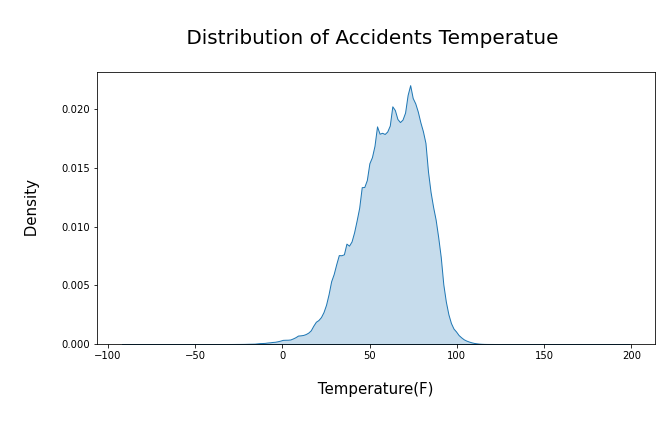

In [37]:
plt.figure(figsize = (10,5))
plt.title('\n Distribution of Accidents Temperatue  \n', size=20)
plt.ylabel('\n Density \n', fontsize=15)
plt.xlabel('\n Temperature(F) \n', fontsize=15)
sns.kdeplot(data=df2["Temperature(F)"],shade=True)

#### As Temperature(F) normally distributed, So fill empty data with the mean value.

In [40]:
df2['Temperature(F)'] = df2['Temperature(F)'].fillna(df2['Temperature(F)'].mean())

<AxesSubplot:title={'center':'\n Distribution of Accidents Visibility \n'}, xlabel='\n Visibility(mi)\n', ylabel='\n Density \n'>

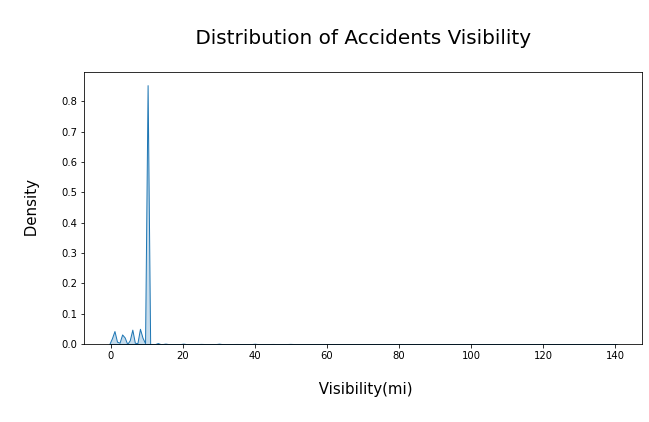

In [7]:
plt.figure(figsize = (10,5))
plt.title('\n Distribution of Accidents Visibility \n', size=20)
plt.ylabel('\n Density \n', fontsize=15)
plt.xlabel('\n Visibility(mi)\n', fontsize=15)
sns.kdeplot(data=df2["Visibility(mi)"],shade=True)

#### Visibility(mi) is right skewed. So replacing null values with a median value is more suitable.

In [41]:
df2['Visibility(mi)'] = df2['Visibility(mi)'].fillna(df2['Visibility(mi)'].mean())

<AxesSubplot:title={'center':'\n Distribution of Accidents Humidity \n'}, xlabel='\n Humidity(%) \n', ylabel='\n Density \n'>

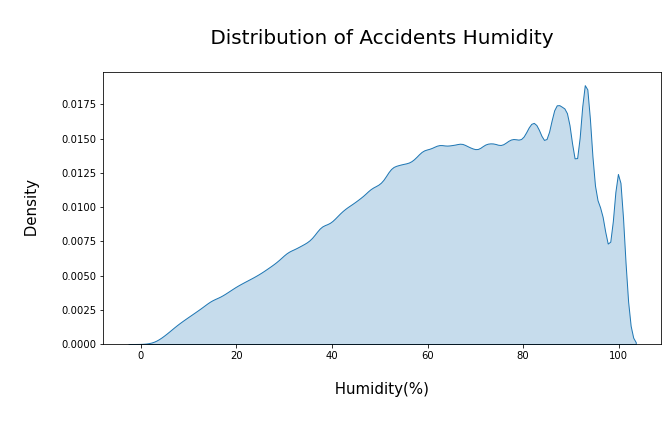

In [42]:
plt.figure(figsize = (10,5))
plt.title('\n Distribution of Accidents Humidity \n', size=20)
plt.ylabel('\n Density \n', fontsize=15)
plt.xlabel('\n Humidity(%) \n', fontsize=15)
sns.kdeplot(data=df2["Humidity(%)"],shade=True)

#### Humidity(%) though has a left skwed distribution. I still used the mode value to fill out the Null.

In [43]:
df2['Humidity(%)'] = df2['Humidity(%)'].fillna(df2['Humidity(%)'].mode())

#### Value imputation
#### Since this is a huge dataset, techniques like KNN Imputer will take a lot of time, even days, which will be computationally very expensive . Thus, I will be filling nan values with mean values.

<AxesSubplot:title={'center':'\n Distribution of Accidents Humidity \n'}, xlabel='\n Wind_Chill(F) \n', ylabel='\n Density \n'>

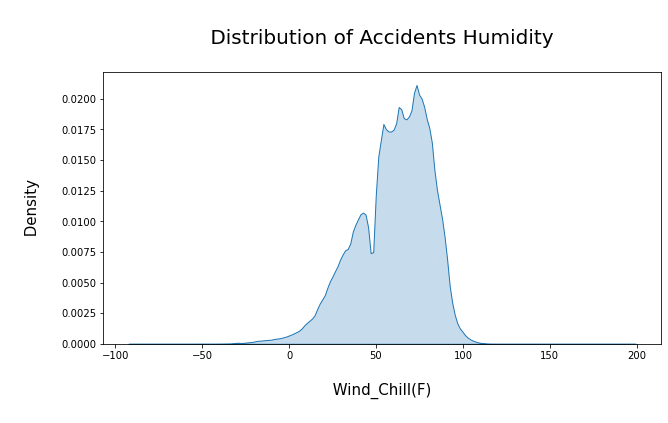

In [11]:
plt.figure(figsize = (10,5))
plt.title('\n Distribution of Accidents Humidity \n', size=20)
plt.ylabel('\n Density \n', fontsize=15)
plt.xlabel('\n Wind_Chill(F) \n', fontsize=15)
sns.kdeplot(data=df["Wind_Chill(F)"],shade=True)

In [44]:
df2['Wind_Chill(F)'] = df2['Wind_Chill(F)'].fillna(df2['Wind_Chill(F)'].mean())

<AxesSubplot:title={'center':'\n Distribution of Accidents Humidity \n'}, xlabel='\nPressure(in)\n', ylabel='\n Density \n'>

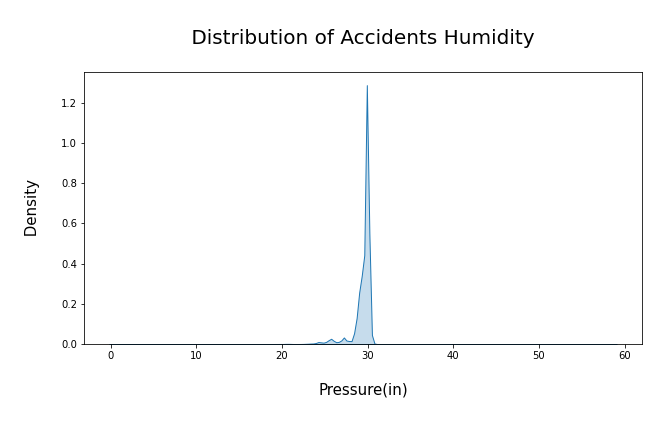

In [45]:
plt.figure(figsize = (10,5))
plt.title('\n Distribution of Accidents Humidity \n', size=20)
plt.ylabel('\n Density \n', fontsize=15)
plt.xlabel('\nPressure(in)\n', fontsize=15)
sns.kdeplot(data=df2["Pressure(in)"],shade=True)

In [47]:
num_cols =['Humidity(%)','Pressure(in)','Wind_Speed(mph)']
for col in num_cols:
    df2[col] = df2[col].fillna(df2[col].mean())

#### To prepare the dataset for further analysis, some additional columns are added

- Time_Diff: Time difference between start time and end time of the accident
- Year: Year of start time
- Month: Month of start time
- Day: Day of start time
- Hour: Hour of start time

In [48]:
# fixing Weather_Timestamp
df2['Weather_Timestamp'] = pd.to_datetime(df2['Weather_Timestamp'])
    
# we will convert the severity variable also to a ordinal variable
df2['Severity'] = pd.Categorical(df2['Severity'], ordered=True)

In [49]:
#### Extract year, month, day, hour, weekday, and time to clear accidents 
# Convert Start_Time and End_Time to datetypes
df2['Start_Time'] = pd.to_datetime(df2['Start_Time'], errors='coerce')
df2['End_Time'] = pd.to_datetime(df2['End_Time'], errors='coerce')

# Extract year, month, day, hour and weekday
df2['Year']=df2['Start_Time'].dt.year
df2['Month']=df2['Start_Time'].dt.strftime('%b')
df2['Day']=df2['Start_Time'].dt.day
df2['Hour']=df2['Start_Time'].dt.hour
df2['Weekday']=df2['Start_Time'].dt.strftime('%a')
df2['duration'] = (df2['End_Time'] - df2['Start_Time']).values.astype('float')
df2.drop(columns=['Start_Time','End_Time'],inplace=True)

#### Continuous Weather Features¶
#### Normalize features with extreamly skewed distribution first.

In [50]:
df2['Pressure_bc']= boxcox(df2['Pressure(in)'].apply(lambda x: x+1),lmbda=6)
df2['Visibility_bc']= boxcox(df2['Visibility(mi)'].apply(lambda x: x+1),lmbda = 0.1)
df2['Wind_Speed_bc']= boxcox(df2['Wind_Speed(mph)'].apply(lambda x: x+1),lmbda=-0.2)

In [57]:
cor = df.corr()

#Correlation with output variable
cor_target = abs(cor["Severity"])
 
cor_target

relevant_features = cor_target[cor_target>0.02]
relevant_features

Severity           1.000000
Start_Lat          0.089207
Start_Lng          0.114063
Distance(mi)       0.092140
Temperature(F)     0.045335
Wind_Chill(F)      0.097459
Humidity(%)        0.037802
Pressure(in)       0.043883
Wind_Speed(mph)    0.048382
Crossing           0.035382
Junction           0.045928
Name: Severity, dtype: float64

#### outliers Treatment

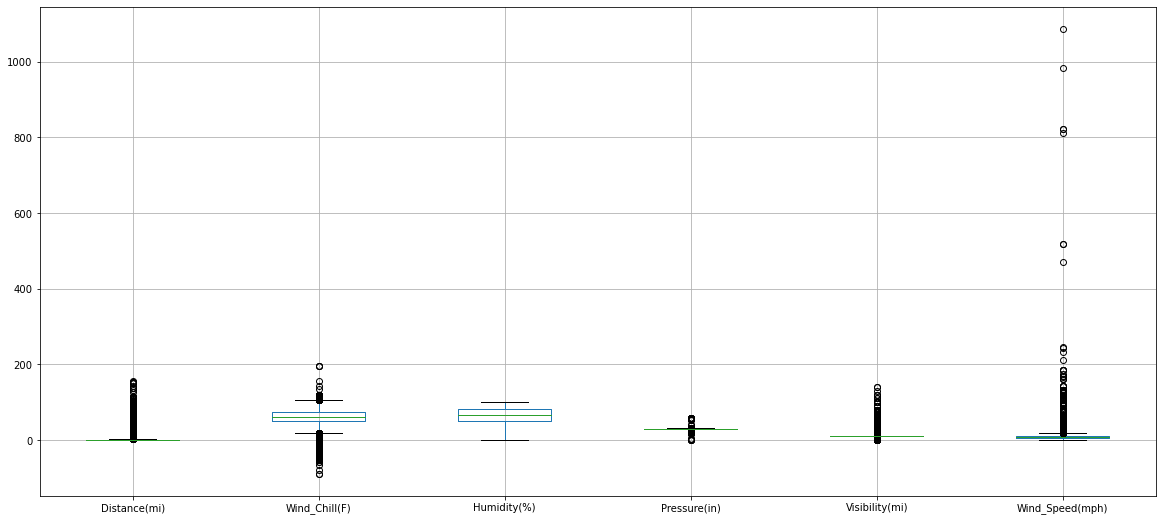

In [26]:
cols_with_outliers = ['Distance(mi)','Wind_Chill(F)','Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)','duration']
df2[cols_with_outliers[:-1]].boxplot(figsize=(20,9));

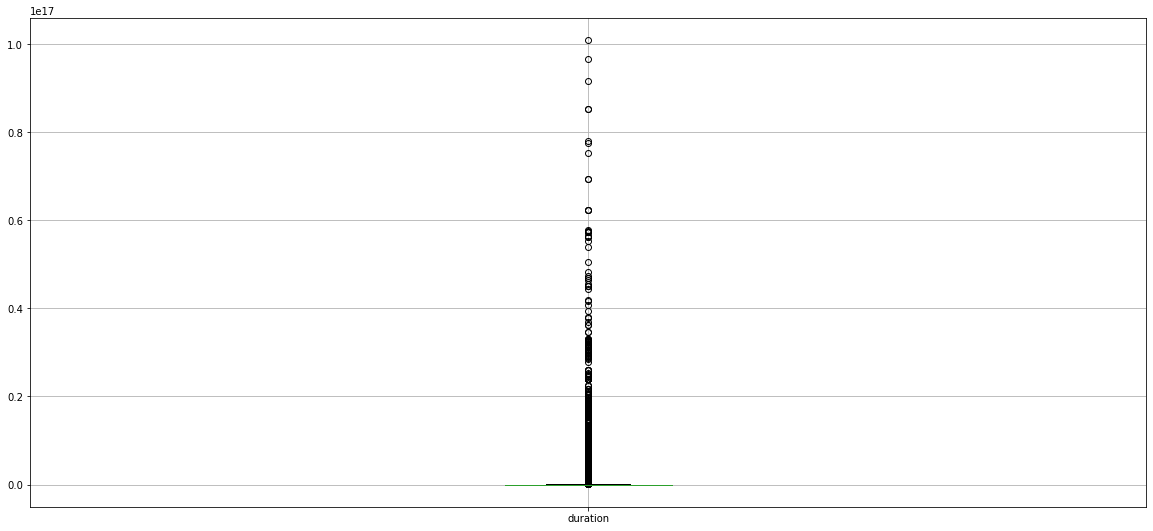

In [27]:
df2[cols_with_outliers[-1]].to_frame().boxplot(figsize=(20,9));

In [28]:
# creating a function that removes outliers statisticaly. 
def remove_outliers(column):
    Q1 = column.quantile(.25)
    Q3 = column.quantile(.75)
    IQR = Q3 - Q1
    column = column[((Q1 - 1.5 * IQR) <= column) & (column  <= (Q3 + 1.5 * IQR))]
    return column

In [30]:
# looping on the columns with outliers to remove the outliers.
for col in cols_with_outliers:
    df1[col] = remove_outliers(df1[col])

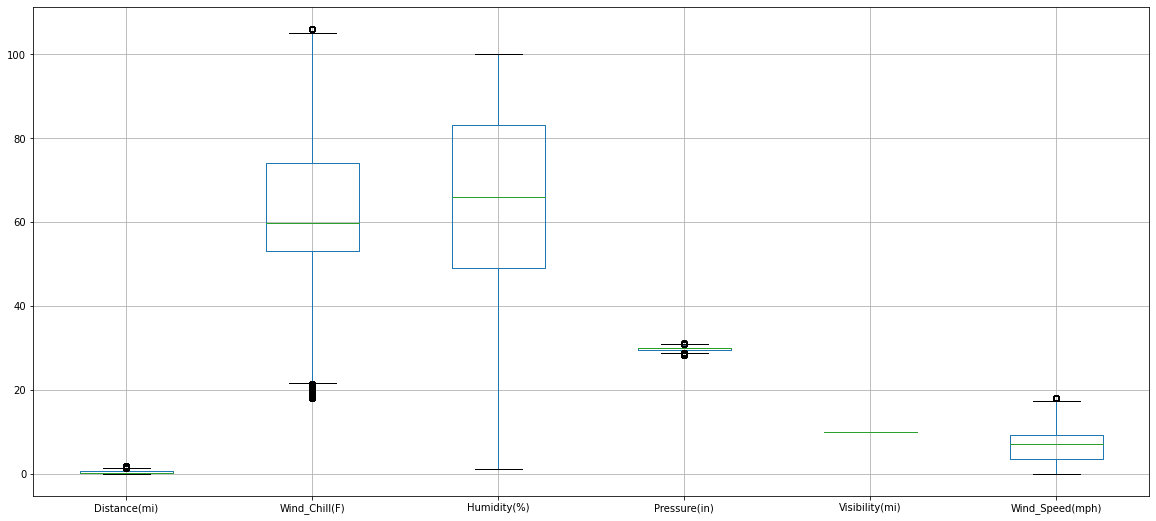

In [31]:
df1[cols_with_outliers[:-1]].boxplot(figsize=(20,9));

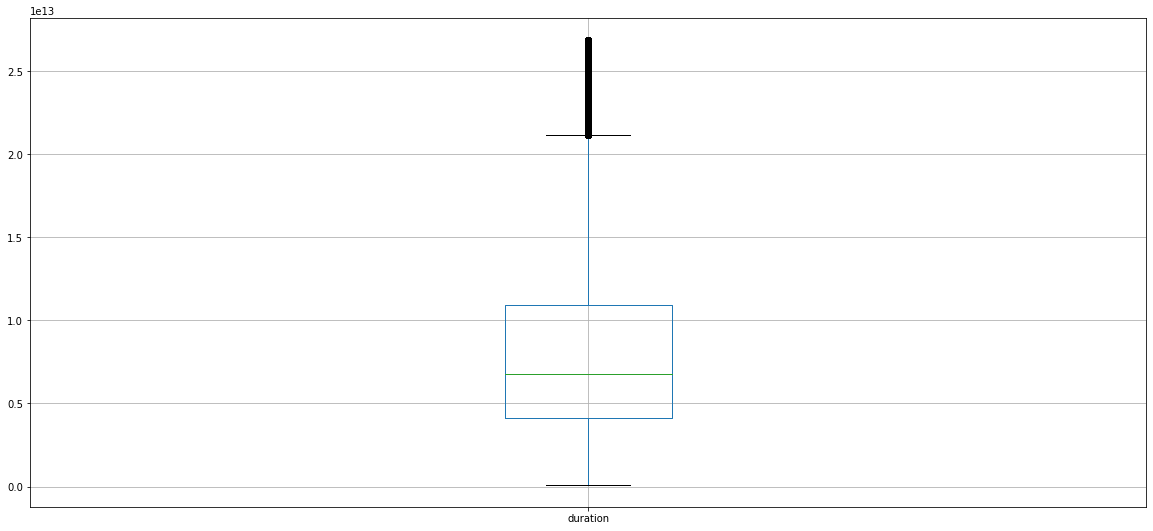

In [32]:
df1['duration'].to_frame().boxplot(figsize=(20,9));

In [59]:
drop_list = ['ID','Start_Lat','Start_Lng','Description']

In [60]:
df2.drop(columns=drop_list,inplace=True)

In [62]:
df2.head()

,Severity,Distance(mi),Side,State,Country,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),...,Turning_Loop,Year,Month,Day,Hour,Weekday,duration,Pressure_bc,Visibility_bc,Wind_Speed_bc
0,3,3.230,R,OH,us,2016-02-08 00:53:00,42.1,36.100000,58.0,29.76,...,False,2016,Feb,8,0,Mon,2.160000e+13,1.411779e+08,2.709816,1.926813
1,2,0.747,R,OH,us,2016-02-08 05:58:00,36.9,59.658231,91.0,29.68,...,False,2016,Feb,8,5,Mon,2.160000e+13,1.389891e+08,2.709816,1.732878
2,2,0.055,R,OH,us,2016-02-08 05:53:00,36.0,59.658231,97.0,29.70,...,False,2016,Feb,8,6,Mon,2.160000e+13,1.395337e+08,2.709816,1.732878
3,2,0.123,R,OH,us,2016-02-08 06:54:00,39.0,59.658231,55.0,29.65,...,False,2016,Feb,8,6,Mon,2.160000e+13,1.381757e+08,2.709816,1.732878
4,3,0.500,R,OH,us,2016-02-08 07:53:00,37.0,29.800000,93.0,29.69,...,False,2016,Feb,8,7,Mon,2.160000e+13,1.392612e+08,2.709816,1.926813


In [65]:
# splitting the data
df2.dropna(axis=0,subset = ['Severity'], inplace = True)

X_train_full = df2.drop(['Severity','Weather_Timestamp'], axis =1)
y_train_full = df2.Severity

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full,y_train_full,test_size=0.8, random_state=42)

In [69]:
# classifying each column by its data type
cats = [column for column in X_train.columns if df2[column].dtype == 'object']
bools = [column for column in X_train.columns if df2[column].dtype == 'bool']
nums = [column for column in X_train.columns if df2[column].dtype not in ['bool','object']]

In [71]:
# A categorical transformer.
cat_trans = Pipeline(steps = [
    ('imputer',SimpleImputer(strategy = 'most_frequent')),
    ('ohe',OneHotEncoder(handle_unknown = 'ignore'))
])

# A numrical transformer.
num_trans = Pipeline(steps = [
    ('imputer',KNNImputer(n_neighbors = 5)),
    ('scaler',StandardScaler())
])

bool_trans = Pipeline(
    steps=[("imputer", KNNImputer()), 
           ("ohe", OneHotEncoder(handle_unknown = 'ignore'))])

# A preprocessor that combines the two previous transformers.
preprocessor = ColumnTransformer(transformers = [
    ('num', num_trans, nums),
    ('cat', cat_trans, cats),
    ('bool', bool_trans, bools)
],
    remainder = "drop")

In [72]:
# fitting the data into my preprocessor.
X_train_trans = preprocessor.fit_transform(X_train.iloc[:40000,:])
X_valid_trans = preprocessor.transform(X_valid.iloc[:10000,:])